<a href="https://colab.research.google.com/github/misha345a/SpaCy_BioNER_Transformers/blob/main/SpaCy_BioNER_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers
!pip install --upgrade spacy
!pip install spacy-transformers

In [ ]:
# check that GPU is enabled
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  8 22:14:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# library imports
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from spacy import displacy
from spacy.tokens import DocBin
from spacy.util import filter_spans
from datetime import datetime
import json
import re

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

In [ ]:
# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

# suppress all warnings
# warnings.simplefilter('ignore')

# expand notebook display options for dataframes
pd.set_option('display.max_colwidth', 200)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 300

## Data Preprocessing

In [ ]:
# load the dataset
df = pd.read_csv('/PATH_TO_DATA.csv', lineterminator='\n', usecols=range(6))

In [ ]:
# there are rows with missing keywords; we need to remove them
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3703 non-null   int64 
 1   description        3703 non-null   object
 2   medical_specialty  3703 non-null   object
 3   sample_name        3703 non-null   object
 4   transcription      3679 non-null   object
 5   keywords           3023 non-null   object
dtypes: int64(1), object(5)
memory usage: 173.7+ KB


In [ ]:
# drop irrelevant columns and rows w/ missing data
df = df[['transcription', 'keywords']].copy(deep=True)
df.dropna(how='any', inplace=True)

In [ ]:
# 2999 rows remaining
len(df)

2999

## Text Cleaning

In [ ]:
def text_cleaning(text):
  text = re.sub(r"NOTE,:.+", "", text, flags=re.IGNORECASE) # remove transcription disclaimers
  text = re.sub(r"[A-Z]{4,}:\s?,", "", text)  # remove subheadings (PROCEDURE, IMPRESSION, etc.)
  text = re.sub(r"\d\.", "", text) # remove number lists (1., 2.)
  text = re.sub(r"([:.])\s{0,},", r"\1 ", text) # remove instances of ".," or ": ,"
  text = re.sub(r",$", "", text) # remove trailing commas
  text = re.sub(r"\s{2,}", " ", text) # shorten lengthy spacing 
  text = text.lower().strip()
  return text

In [ ]:
df['keywords'] = df['keywords'].apply(text_cleaning)
df['transcription'] = df['transcription'].progress_apply(text_cleaning)

  0%|          | 0/2999 [00:00<?, ?it/s]

In [ ]:
df.head()

,transcription,keywords
0,"this 23-year-old white female presents with complaint of allergies. she used to have allergies when she lived in seattle but she thinks they are worse here. in the past, she has tried claritin, an...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic"
1,"past medical history: he has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. he exercises three times a week at h...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic,..."
2,"i have seen abc today. he is a very pleasant gentleman who is 42 years old, 344 pounds. he is 5'9"". he has a bmi of 5 he has been overweight for ten years since the age of 33, at his highest he wa...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, ..."
3,"2-d m-mode: , left atrial enlargement with left atrial diameter of 7 cm. normal size right and left ventricle. normal lv systolic function with left ventricular ejection fraction of 51%. normal lv...","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation..."
4,the left ventricular cavity size and wall thickness appear normal. the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. there...,"cardiovascular / pulmonary, 2-d, doppler, echocardiogram, annular, aortic root, aortic valve, atrial, atrium, calcification, cavity, ejection fraction, mitral, obliteration, outflow, regurgitation..."


## Text Cleaning Example

In [ ]:
example = "DESCRIPTION:,1.  Normal cardiac chambers size.,2.  Normal left ventricular size.,"
print(f"ORIGINAL: {example}")
print(f" CLEANED: {text_cleaning(example)}")

ORIGINAL: DESCRIPTION:,1.  Normal cardiac chambers size.,2.  Normal left ventricular size.,
 CLEANED: normal cardiac chambers size. normal left ventricular size.


## Keyword Analysis

In [ ]:
# remove the first term in each keyword set; 
# this term only defines the specialty and is not an entity
df['keywords'] = df['keywords'].apply(lambda x: re.sub(r"[a-z /]*, ", '', x , 1))

In [ ]:
# count frequency of each keyword
keyword_counts = pd.Series(df['keywords'].str.cat().replace(', ', ',').split(',')).value_counts()
keyword_counts = keyword_counts.sort_values(ascending=True)

In [ ]:
# number of unique keywords or "entities"
len(keyword_counts)

10339

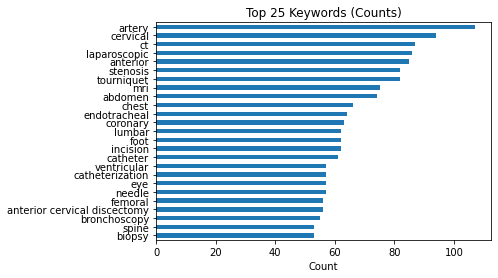

In [ ]:
# plot the counts of the top 25 keywords
keyword_counts[-25:].plot(kind='barh')
plt.title("Top 25 Keywords (Counts)")
plt.xlabel("Count")
plt.show()

In [ ]:
# number of keywords with less than 3 appearances in the training data
len(keyword_counts[keyword_counts < 3])

7237

This data has a number of imperfections. Quality assurance is meaningful here to improve the predictabilty of the model.

TODO
* Define and execute a plan to handle abbreviations

## Annotation

In [ ]:
# this list will contain all annotated examples
annotated_list = [] 

def structure_data(text, kw_list):
  """
  Automatically extract the spans of each keyword in text.
  Shape the data into JSON annotation format.
  """
  results = []
  entities = []

  kw_list = kw_list.split(', ')
  
  # search for instances of keywords within the text (ignoring letter case)
  for kw in kw_list:
    search = re.finditer(kw, text, flags=re.IGNORECASE)
      
    # store the start/end character positions
    all_instances = [[m.start(), m.end()] for m in search] 
      
    # if the callable_iterator found matches, create an 'entities' list
    if len(all_instances)>0:
      for i in all_instances:
        start = i[0]
        end = i[1]
        entities.append((start, end, "CLINICAL"))
          
  # add any found entities into a JSON format within collective_dict
  if len(entities)>0:
    results = [text, {"entities": entities}]
    annotated_list.append(results)

In [ ]:
%%capture
# the data is currently ordered by specialty
# randomly shuffle the entire dataset
shuffled = df.sample(frac=1, random_state=42)

df.apply(lambda x: structure_data(x['transcription'], x['keywords']), axis=1)

In [ ]:
# split the annotated data into 80% train, 20% test data
train_test_split = int(len(annotated_list)*0.80)

TRAIN_DATA = {"DATA": annotated_list[:train_test_split]}
TEST_DATA = {"DATA": annotated_list[train_test_split:]}

In [ ]:
# sneak peek into the training data
TRAIN_DATA['DATA'][0]

['this 23-year-old white female presents with complaint of allergies. she used to have allergies when she lived in seattle but she thinks they are worse here. in the past, she has tried claritin, and zyrtec. both worked for short time but then seemed to lose effectiveness. she has used allegra also. she used that last summer and she began using it again two weeks ago. it does not appear to be working very well. she has used over-the-counter sprays but no prescription nasal sprays. she does have asthma but doest not require daily medication for this and does not think it is flaring up. her only medication currently is ortho tri-cyclen and the allegra. she has no known medicine allergies. vitals: weight was 130 pounds and blood pressure 124/7,heent: her throat was mildly erythematous without exudate. nasal mucosa was erythematous and swollen. only clear drainage was seen. tms were clear. neck: supple without adenopathy. lungs: clear. allergic rhinitis. plan: she will try zyrtec instead o

## Saving the Training Data

In [ ]:
def save_data(filename, data):
  """
  Option to timestamp and save JSON data to local directory.
  """
  # add a timestamp to the filename
  now = datetime.now() 
  datetime_str = now.strftime("%m_%d_%Y-%H.%MMT") # using military time
  
  split = filename.split('.')
  split[0] = split[0]+'--'+datetime_str+'.'
  filename = ''.join(split)
  
  with open (filename, "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)

# save_data('Training_Data', TRAIN_DATA)
# save_data('Test_Data', TEST_DATA)

## Preparing SpaCy Doc Objects

In [ ]:
nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object

In [ ]:
def create_training(DATA):
  """
  Convert the examples from JSON format into SpaCy Doc objects. 
  The Doc objects are then stored in a collective DocBin class.
  """
  db = DocBin()
  for text, annot in tqdm(DATA):
    doc = nlp.make_doc(text)
    ents = []

    # create span objects
    for start, end, label in annot["entities"]:
      span = doc.char_span(start, end, label=label, alignment_mode="contract") 

      # skip if the character indices do not map to a valid span
      if span is None:
          print("Skipping entity.")
      else:
          ents.append(span)

    # remove duplicate or overlapping span objects (while keeping the first longest span)
    filtered_ents = filter_spans(ents)
   
    # pack Doc objects into DocBin
    doc.ents = filtered_ents
    db.add(doc) 

  return db

In [ ]:
%%capture 

TRAIN_DATA_DOC = create_training(TRAIN_DATA['DATA'])
TEST_DATA_DOC = create_training(TEST_DATA['DATA'])

In [ ]:
# export results 
TRAIN_DATA_DOC.to_disk("./TRAIN_DATA/TRAIN_DATA.spacy")
TEST_DATA_DOC.to_disk("./TEST_DATA/TEST_DATA.spacy")

## SpaCy Model Training

In [ ]:
# auto-fill the config file with any remaining default parameters 
!python -m spacy init fill-config /content/base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
# validate the training and development data
!python -m spacy debug data /content/config.cfg


============================ Data file validation ============================
Downloading: 100% 28.0/28.0 [00:00<00:00, 28.4kB/s]
Downloading: 100% 385/385 [00:00<00:00, 370kB/s]
Downloading: 100% 220k/220k [00:00<00:00, 312kB/s]
Downloading: 100% 420M/420M [00:06<00:00, 70.1MB/s]
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you

In [ ]:
# train the model using GPU
!python -m spacy train --gpu-id 0 /content/config.cfg --output ./output

✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-05-08 22:17:22,454] [INFO] Set up nlp object from config
[2022-05-08 22:17:22,463] [INFO] Pipeline: ['transformer', 'ner']
[2022-05-08 22:17:22,467] [INFO] Created vocabulary
[2022-05-08 22:17:22,468] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another arch

## Evaluation

In [ ]:
!python -m spacy evaluate /content/output/model-best /content/TRAIN_DATA/TRAIN_DATA.spacy --gold-preproc --output ./eval --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK     100.00
NER P   66.38 
NER R   70.68 
NER F   68.46 
SPEED   17058 


=============================== NER (per type) ===============================

               P       R       F
CLINICAL   66.38   70.68   68.46

✔ Saved results to eval


## Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save model outputs to Drive
!cp -r "/content/output" "/content/drive/MyDrive/BioNER_Model"

## Testing

In [ ]:
# load the trained model
nlp_output = spacy.load("/content/output/model-best")

In [ ]:
# example text
model_test = df.iloc[3,0]
model_test

'2-d m-mode: , left atrial enlargement with left atrial diameter of 7 cm. normal size right and left ventricle. normal lv systolic function with left ventricular ejection fraction of 51%. normal lv diastolic function. no pericardial effusion. normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve. pa systolic pressure is 36 mmhg. , mild mitral and tricuspid regurgitation. trace aortic and pulmonary regurgitation.'

In [ ]:
# pass the test instance into the trained pipeline
doc = nlp_output(model_test)

In [ ]:
# customize the label colors
colors = {"CLINICAL": "linear-gradient(90deg, #E1D436, #F59710)"}
options = {"ents": ["CLINICAL"], "colors": colors}

In [ ]:
# visualize the identified entities
displacy.render(doc, style="ent", jupyter=True, options=options)

In [ ]:
# print out the identified entities
for ent in doc.ents:
    if ent.label_ == "CLINICAL":
        print(ent.text)

2-d m-mode
atrial enlargement
normal lv
systolic function
ejection fraction
normal lv
diastolic function
pericardial effusion
aortic valve
mitral valve
tricuspid valve
pulmonary valve
mitral
tricuspid
regurgitation
regurgitation
